# Preprocessing

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import re
import random
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, Ridge, RidgeCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, TransformedTargetRegressor

In [2]:
# from `input.ipynb`

from dataclasses import dataclass

import numpy as np
import pandas as pd

# Helper class
@dataclass
class Note:
    note: int = 0       # The pitch
    octave: int = 0     # The (Midi) octave
    rest: int = 0       # Whether the note is a rest
    duration: int = 0   # The duration of the note (in 1/16 second intervals)

# Options for creating the dataframe. VOICE = which voice to pick, LAG = how many periods to lag for.
VOICE = 3
LAG = 8

# Import the csv
piano_input = pd.read_csv('F.txt', sep='\t', header=None)

# Transform piano key pitch (A0 = 1) to Midi pitch (A0 = 21)
# Different sources say different numbers for A0. Might be 9 or 21. :| 9 seems to be A(-1) generally though.
# If we map octave -1 to index 0 (which is the easiest probably), then we need A0 = 21.
midi_input = piano_input.where(piano_input == 0, piano_input + 20)
# Take the voice we are working on
voice_input = midi_input.iloc[:, VOICE]

# Create an output dataframe
notes = []
# Process the first note
cur = Note(voice_input[0] % 12, voice_input[0] // 12, 1 if voice_input[0] == 0 else 0, 1)

# Process the rest of the notes
for entry in voice_input[1:]:
    note = entry % 12
    octv = entry // 12
    if cur.note == note and cur.octave == octv:
        cur.duration += 1
    else:
        notes.append(cur)
        cur = Note(note, octv, 1 if note == 0 else 0, 1)

# Pandas can automatically convert a list of dataclass objects to dataframes!
notes_df = pd.DataFrame(notes)

# Create a lagged input dataframe
notes_lagged_df = notes_df.copy()

for lag in range(1, LAG + 1):
    lagged = notes_df.shift(lag)
    lagged.columns = [f'{col_name}_lag{lag}' for col_name in notes_df.columns]
    notes_lagged_df = pd.concat((notes_lagged_df, lagged), axis=1)

# Drop rows containing NA (i.e. the first LAG rows basically)
notes_lagged_df = notes_lagged_df.dropna()

# Show first 10 notes
notes_lagged_df.head(10)

,note,octave,rest,duration,note_lag1,octave_lag1,rest_lag1,duration_lag1,note_lag2,octave_lag2,...,rest_lag6,duration_lag6,note_lag7,octave_lag7,rest_lag7,duration_lag7,note_lag8,octave_lag8,rest_lag8,duration_lag8
8,5,5,0,12,2.0,5.0,0.0,8.0,9.0,5.0,...,0.0,12.0,2.0,5.0,0.0,8.0,0.0,0.0,1.0,8.0
9,11,4,0,4,5.0,5.0,0.0,12.0,2.0,5.0,...,0.0,4.0,9.0,5.0,0.0,12.0,2.0,5.0,0.0,8.0
10,4,5,0,8,11.0,4.0,0.0,4.0,5.0,5.0,...,0.0,16.0,7.0,5.0,0.0,4.0,9.0,5.0,0.0,12.0
11,9,4,0,4,4.0,5.0,0.0,8.0,11.0,4.0,...,0.0,16.0,5.0,5.0,0.0,16.0,7.0,5.0,0.0,4.0
12,4,5,0,4,9.0,4.0,0.0,4.0,4.0,5.0,...,0.0,16.0,7.0,5.0,0.0,16.0,5.0,5.0,0.0,16.0
13,9,5,0,4,4.0,5.0,0.0,4.0,9.0,4.0,...,0.0,8.0,9.0,5.0,0.0,16.0,7.0,5.0,0.0,16.0
14,7,5,0,4,9.0,5.0,0.0,4.0,4.0,5.0,...,0.0,12.0,2.0,5.0,0.0,8.0,9.0,5.0,0.0,16.0
15,5,5,0,4,7.0,5.0,0.0,4.0,9.0,5.0,...,0.0,4.0,5.0,5.0,0.0,12.0,2.0,5.0,0.0,8.0
16,2,5,0,4,5.0,5.0,0.0,4.0,7.0,5.0,...,0.0,8.0,11.0,4.0,0.0,4.0,5.0,5.0,0.0,12.0
17,10,5,0,4,2.0,5.0,0.0,4.0,5.0,5.0,...,0.0,4.0,4.0,5.0,0.0,8.0,11.0,4.0,0.0,4.0


# Models

Change here: duration also as categorical

In [3]:
dfV1 = notes_lagged_df
# columns as categories or contineous variables
cate_cols = [i for i in dfV1.columns.values if (re.search('note', i) or re.search('rest', i) or re.search('duration', i))]
cont_cols = [i for i in dfV1.columns.values if (re.search('octave', i))]
print(cate_cols)
print(cont_cols)

['note', 'rest', 'duration', 'note_lag1', 'rest_lag1', 'duration_lag1', 'note_lag2', 'rest_lag2', 'duration_lag2', 'note_lag3', 'rest_lag3', 'duration_lag3', 'note_lag4', 'rest_lag4', 'duration_lag4', 'note_lag5', 'rest_lag5', 'duration_lag5', 'note_lag6', 'rest_lag6', 'duration_lag6', 'note_lag7', 'rest_lag7', 'duration_lag7', 'note_lag8', 'rest_lag8', 'duration_lag8']
['octave', 'octave_lag1', 'octave_lag2', 'octave_lag3', 'octave_lag4', 'octave_lag5', 'octave_lag6', 'octave_lag7', 'octave_lag8']


## model for `rest`

In [4]:
rcv_pipe_rest = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown = 'ignore'), [i for i in cate_cols if (i != 'rest' and i != 'note' and i != 'duration')])
    ),
    RidgeClassifierCV(alphas = [0.001, 0.01, 0.1, 1., 10., 100., 1000.], cv = 10)
)
rcv_pipe_rest.fit(X = dfV1[dfV1.columns.drop(['rest', 'note', 'octave', 'duration'])], y = dfV1['rest'])
rcv_pipe_rest['ridgeclassifiercv'].alpha_

100.0

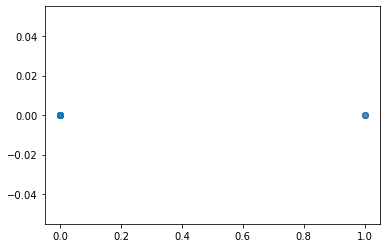

In [5]:
rcv_pipe_rest_pred = rcv_pipe_rest.predict(X = dfV1[dfV1.columns.drop(['note', 'octave', 'duration'])])
plt.scatter(dfV1.rest, rcv_pipe_rest_pred, alpha = 0.01)
# it never predicts a rest, which is fine?
# then we don't need to predict duration for rests.

## model for `octave`

In [6]:
rcv_pipe_octave = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown = 'ignore'), [i for i in cate_cols if (i != 'note' and i != 'duration')])
    ),
    # here we need to transform the outcome to the closest integer.
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas = [0.001, 0.01, 0.1, 1., 10., 100., 1000.], cv = 10),
        func=lambda x : x,
        inverse_func=lambda x: np.round(x)
    )
)
## here we need to filter out rests
rcv_pipe_octave.fit(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['note', 'octave', 'duration'])], 
                    y = dfV1[dfV1.rest != 1]['octave'])
rcv_pipe_octave['transformedtargetregressor'].regressor_.alpha_

100.0

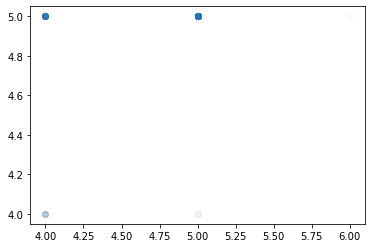

In [7]:
rcv_pipe_octave_pred = rcv_pipe_octave.predict(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['note', 'octave', 'duration'])])
plt.scatter(dfV1[dfV1.rest != 1]['octave'], rcv_pipe_octave_pred, alpha = 0.01)

## model for `note`

In [8]:
rcv_pipe_note = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown = 'ignore'), [i for i in cate_cols if (i != 'note' and i != 'duration')])
    ),
    RidgeClassifierCV(alphas = [0.001, 0.01, 0.1, 1., 10., 100., 1000.], cv = 10)
)
## here we need to filter out rests
rcv_pipe_note.fit(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['note', 'duration'])], 
                  y = dfV1[dfV1.rest != 1]['note'])
rcv_pipe_note['ridgeclassifiercv'].alpha_

C:\Users\jingm\.conda\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


10.0

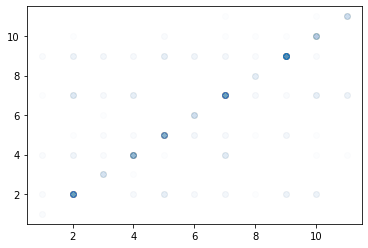

In [9]:
rcv_pipe_note_pred = rcv_pipe_note.predict(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['note', 'duration'])])
plt.scatter(dfV1[dfV1.rest != 1]['note'], rcv_pipe_note_pred, alpha = 0.01)

## model for `duration`

In [10]:
rcv_pipe_duration = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown = 'ignore'), [i for i in cate_cols if (i != 'duration')])
    ),
    RidgeClassifierCV(alphas = [0.001, 0.01, 0.1, 1., 10., 100., 1000.], cv = 10)
)
## here we need to filter out rests
rcv_pipe_duration.fit(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['duration'])], 
                    y = dfV1[dfV1.rest != 1]['duration'])
rcv_pipe_note['ridgeclassifiercv'].alpha_

C:\Users\jingm\.conda\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


10.0

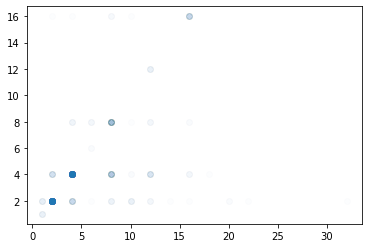

In [11]:
rcv_pipe_duration_pred = rcv_pipe_duration.predict(X = dfV1[dfV1.rest != 1][dfV1.columns.drop(['duration'])])
plt.scatter(dfV1[dfV1.rest != 1]['duration'], rcv_pipe_duration_pred, alpha = 0.01)
# this looks better.

# Prediction

In [12]:
dfV1_pred = dfV1
for i in range(100):
    # making the next row with blanks
    temp_next_row = pd.DataFrame([np.nan, np.nan, np.nan, np.nan]+dfV1_pred.tail(1).iloc[:,:-4].values.tolist()[0][:]).T
    temp_next_row.columns = dfV1_pred.columns
    dfV1_pred = dfV1_pred.append(temp_next_row, ignore_index=True)
    
    # predict the next rest (not actually predicting)
    temp_v1_rest = 0
    dfV1_pred.iloc[-1,2] = temp_v1_rest
    # predict the next octave
    temp_v1_octave = rcv_pipe_octave.predict(X=dfV1_pred.tail(1).drop(columns = ['octave', 'note', 'duration']))
    dfV1_pred.iloc[-1,1] = temp_v1_octave
    # predict the next note
    temp_v1_note = rcv_pipe_note.predict(X=dfV1_pred.tail(1).drop(columns = ['note', 'duration']))
    dfV1_pred.iloc[-1,0] = temp_v1_note
    # predict the next duration
    temp_v1_duration = rcv_pipe_duration.predict(X=dfV1_pred.tail(1).drop(columns = ['duration']))
    dfV1_pred.iloc[-1,3] = temp_v1_duration

In [13]:
dfV1_pred = dfV1
for i in range(100):
    # making the next row with blanks
    temp_next_row = pd.DataFrame([np.nan, np.nan, np.nan, np.nan]+dfV1_pred.tail(1).iloc[:,:-4].values.tolist()[0][:]).T
    temp_next_row.columns = dfV1_pred.columns
    dfV1_pred = dfV1_pred.append(temp_next_row, ignore_index=True)
    
    # predict the next rest (not actually predicting)
    temp_v1_rest = 0
    dfV1_pred.iloc[-1,2] = temp_v1_rest
    # predict the next octave
    temp_v1_octave = rcv_pipe_octave.predict(X=dfV1_pred.tail(1).drop(columns = ['octave', 'note', 'duration']))
    dfV1_pred.iloc[-1,1] = temp_v1_octave
    # predict the next note
    # temp_v1_note = rcv_pipe_note.predict(X=dfV1_pred.tail(1).drop(columns = ['note', 'duration']))
    d = rcv_pipe_note.decision_function(X=dfV1_pred.tail(1).drop(columns = ['note', 'duration']))
    probs = [np.exp(i) / np.sum(np.exp(i)) for i in d]
    temp_v1_note = random.choices(rcv_pipe_note.classes_, weights=probs[0])[0]
    dfV1_pred.iloc[-1,0] = temp_v1_note
    # predict the next duration
    # temp_v1_duration = rcv_pipe_duration.predict(X=dfV1_pred.tail(1).drop(columns = ['duration']))
    d = rcv_pipe_duration.decision_function(X=dfV1_pred.tail(1).drop(columns = ['duration']))
    probs = [np.exp(i) / np.sum(np.exp(i)) for i in d]
    temp_v1_duration = random.choices(rcv_pipe_duration.classes_, weights=probs[0])[0]
    dfV1_pred.iloc[-1,3] = temp_v1_duration
    
    ## we probably need postprocessing here, because later values depend on previous value

In [18]:
dfV1_pred.tail(50)
# duration too long

,note,octave,rest,duration,note_lag1,octave_lag1,rest_lag1,duration_lag1,note_lag2,octave_lag2,...,rest_lag6,duration_lag6,note_lag7,octave_lag7,rest_lag7,duration_lag7,note_lag8,octave_lag8,rest_lag8,duration_lag8
704,2.0,5.0,0.0,18.0,2.0,5.0,0.0,18.0,11.0,5.0,...,0.0,2.0,7.0,5.0,0.0,14.0,10.0,5.0,0.0,16.0
705,3.0,5.0,0.0,1.0,2.0,5.0,0.0,18.0,2.0,5.0,...,0.0,2.0,10.0,5.0,0.0,2.0,7.0,5.0,0.0,14.0
706,11.0,5.0,0.0,22.0,3.0,5.0,0.0,1.0,2.0,5.0,...,0.0,20.0,9.0,5.0,0.0,2.0,10.0,5.0,0.0,2.0
707,1.0,5.0,0.0,16.0,11.0,5.0,0.0,22.0,3.0,5.0,...,0.0,2.0,7.0,5.0,0.0,20.0,9.0,5.0,0.0,2.0
708,1.0,5.0,0.0,14.0,1.0,5.0,0.0,16.0,11.0,5.0,...,0.0,1.0,8.0,5.0,0.0,2.0,7.0,5.0,0.0,20.0
709,9.0,5.0,0.0,2.0,1.0,5.0,0.0,14.0,1.0,5.0,...,0.0,18.0,11.0,5.0,0.0,1.0,8.0,5.0,0.0,2.0
710,4.0,5.0,0.0,8.0,9.0,5.0,0.0,2.0,1.0,5.0,...,0.0,18.0,2.0,5.0,0.0,18.0,11.0,5.0,0.0,1.0
711,5.0,5.0,0.0,4.0,4.0,5.0,0.0,8.0,9.0,5.0,...,0.0,1.0,2.0,5.0,0.0,18.0,2.0,5.0,0.0,18.0
712,4.0,5.0,0.0,8.0,5.0,5.0,0.0,4.0,4.0,5.0,...,0.0,22.0,3.0,5.0,0.0,1.0,2.0,5.0,0.0,18.0
713,4.0,5.0,0.0,2.0,4.0,5.0,0.0,8.0,5.0,5.0,...,0.0,16.0,11.0,5.0,0.0,22.0,3.0,5.0,0.0,1.0
